# Imports

In [245]:
import KNN
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
from math import exp, pi, sqrt
from scipy import stats
from random import shuffle
from KNN import WindowType, Kernel, Metric
from IPython.display import clear_output
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

clear_output(wait=False)

# Normalization

In [246]:
# https://www.kaggle.com/datasets/deepu1109/star-dataset
df = pd.read_csv('stars.csv')
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue,O
236,30839,834042.000000,1194.0000,-10.63,5,Blue,O
237,8829,537493.000000,1423.0000,-10.73,5,White,A
238,9235,404940.000000,1112.0000,-11.23,5,White,A


In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB


In [248]:
df['Star color'] = df['Star color'].rank(method='dense', ascending=False).astype(float)
df['Spectral Class'] = df['Spectral Class'].rank(method='dense', ascending=False).astype(float)
df['Temperature (K)'] = df['Temperature (K)'].astype(float)

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    float64
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    float64
 6   Spectral Class          240 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 13.3 KB


In [250]:
df["Star type"].value_counts()

Star type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

In [251]:
columns_to_normalize = [
    "Temperature (K)",
    "Luminosity(L/Lo)",
    "Radius(R/Ro)",
    "Absolute magnitude(Mv)",
    "Star color",
    "Spectral Class"
]

scaler = MinMaxScaler()

for col in columns_to_normalize:
    df[col] = df[col].map(lambda x: x + 0.1)
    df[col] = scaler.fit_transform(df[[col]])

In [252]:
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,0.029663,2.731275e-09,0.000083,0.876798,0,0.444444,0.166667
1,0.028980,4.944550e-10,0.000075,0.891807,0,0.444444,0.166667
2,0.017367,2.590003e-10,0.000048,0.957473,0,0.444444,0.166667
3,0.022622,1.412729e-10,0.000078,0.893371,0,0.444444,0.166667
4,0.000000,6.828189e-11,0.000049,1.000000,0,0.444444,0.166667
...,...,...,...,...,...,...,...
235,0.972150,4.412776e-01,0.695919,0.062226,5,1.000000,0.000000
236,0.759307,9.818959e-01,0.612777,0.040338,5,1.000000,0.000000
237,0.181025,6.327765e-01,0.730304,0.037211,5,0.388889,1.000000
238,0.191692,4.767253e-01,0.570694,0.021576,5,0.388889,1.000000


# My KNN

In [253]:
train, test = np.split(df.sample(frac=1, random_state=17), [int(.6 * len(df))])
print("train/test size ", len(train), len(test))
X_train = train.drop(columns=["Star type"])
X_test = test.drop(columns=["Star type"])
y_train = train["Star type"]
y_test = test["Star type"]

train/test size  144 96


C:\Users\swerc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [254]:
knn = KNN.KNN(window_param=10, window_type=KNN.WindowType.VARIABLE, kernel=KNN.Kernel.UNIFORM, metric=KNN.Metric.EUCLIDEAN)
default_weights = [1 for _ in range(len(X_train))]
predictions = knn.fit(X_train, y_train, default_weights).predict(X_test)
pd.DataFrame(predictions).value_counts()

0    18
2    18
4    18
3    15
1    14
5    13
Name: count, dtype: int64

In [255]:
y_test_list = y_test.to_list()
correct = 0
for i in range(len(y_test_list)):
    if y_test_list[i] == predictions[i]:
        correct += 1
accuracy = correct / len(y_test_list) * 100
print("Accuracy: ", accuracy)

Accuracy:  96.875


# Sklearn KNN

In [256]:
library_predictions = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train).predict(X_test)
y_test_list = y_test.to_list()
correct = 0
for i in range(len(y_test_list)):
    if y_test_list[i] == predictions[i]:
        correct += 1
accuracy = correct / len(y_test_list) * 100
print("Accuracy: ", accuracy)

Accuracy:  96.875


# Hyperparameter tuning

In [257]:
kr_map = {"uniform": Kernel.UNIFORM, "triangular": Kernel.TRIANGULAR, "epanechnikov": Kernel.EPANECHNIKOV,
          "gaussian": Kernel.GAUSSIAN}
mt_map = {"manhattan": Metric.MANHATTAN, "euclidean": Metric.EUCLIDEAN, "cosine": Metric.COSINE}


def my_objective(window_type, trial):
    if window_type == WindowType.FIXED:
        window_param = trial.suggest_float("h", 0.01, 1)
    else:
        window_param = trial.suggest_int("k", 1, 100)
    kernel = trial.suggest_categorical("Kernel", ["uniform", "triangular", "epanechnikov", "gaussian"])
    metric = trial.suggest_categorical("Metric", ["manhattan", "euclidean", "cosine"])
    predictions = KNN.KNN(window_param, window_type, kr_map[kernel], mt_map[metric]).fit(X_train, y_train, default_weights).predict(X_test)
    y_test_list = y_test.to_list()
    correct = 0
    for i in range(len(y_test_list)):
        if y_test_list[i] == predictions[i]:
            correct += 1
    accuracy = correct / len(y_test_list) * 100
    return accuracy


my_fixed = lambda trial: my_objective(WindowType.FIXED, trial)
my_variable = lambda trial: my_objective(WindowType.VARIABLE, trial)

study = optuna.create_study(direction="maximize")
study.optimize(my_fixed, n_trials=100)
best_fixed = study.best_trial

[I 2024-03-18 23:40:16,875] A new study created in memory with name: no-name-5054df85-6de0-45be-a9ca-f9850b684d2c
[I 2024-03-18 23:40:16,905] Trial 0 finished with value: 93.75 and parameters: {'h': 0.3624758830641581, 'Kernel': 'uniform', 'Metric': 'manhattan'}. Best is trial 0 with value: 93.75.
[I 2024-03-18 23:40:16,933] Trial 1 finished with value: 96.875 and parameters: {'h': 0.873532985393348, 'Kernel': 'triangular', 'Metric': 'euclidean'}. Best is trial 1 with value: 96.875.
[I 2024-03-18 23:40:16,963] Trial 2 finished with value: 95.83333333333334 and parameters: {'h': 0.8064135773185547, 'Kernel': 'uniform', 'Metric': 'euclidean'}. Best is trial 1 with value: 96.875.
[I 2024-03-18 23:40:16,990] Trial 3 finished with value: 92.70833333333334 and parameters: {'h': 0.5515304159165053, 'Kernel': 'gaussian', 'Metric': 'cosine'}. Best is trial 1 with value: 96.875.
[I 2024-03-18 23:40:17,019] Trial 4 finished with value: 75.0 and parameters: {'h': 0.11075695812109229, 'Kernel': 'tr

In [258]:
study = optuna.create_study(direction="maximize")
study.optimize(my_variable, n_trials=50)

[I 2024-03-18 23:40:20,302] A new study created in memory with name: no-name-90a32249-876b-4059-a7ae-0f900b468626
[I 2024-03-18 23:40:20,332] Trial 0 finished with value: 89.58333333333334 and parameters: {'k': 17, 'Kernel': 'uniform', 'Metric': 'manhattan'}. Best is trial 0 with value: 89.58333333333334.
[I 2024-03-18 23:40:20,361] Trial 1 finished with value: 54.166666666666664 and parameters: {'k': 52, 'Kernel': 'uniform', 'Metric': 'euclidean'}. Best is trial 0 with value: 89.58333333333334.
[I 2024-03-18 23:40:20,391] Trial 2 finished with value: 46.875 and parameters: {'k': 85, 'Kernel': 'uniform', 'Metric': 'cosine'}. Best is trial 0 with value: 89.58333333333334.
[I 2024-03-18 23:40:20,423] Trial 3 finished with value: 73.95833333333334 and parameters: {'k': 55, 'Kernel': 'epanechnikov', 'Metric': 'euclidean'}. Best is trial 0 with value: 89.58333333333334.
[I 2024-03-18 23:40:20,459] Trial 4 finished with value: 66.66666666666666 and parameters: {'k': 92, 'Kernel': 'gaussian',

In [259]:
print("fixed window", best_fixed.params)
print("variable window", study.best_trial.params)

fixed window {'h': 0.15078779366411887, 'Kernel': 'gaussian', 'Metric': 'manhattan'}
variable window {'k': 2, 'Kernel': 'gaussian', 'Metric': 'manhattan'}


In [260]:
def lib(trial):
    n_neighbors = trial.suggest_int("k", 1, 100)
    weights = trial.suggest_categorical("Weight function", ["uniform", "distance"])
    algorithm = trial.suggest_categorical("NN Algorithm", ["ball_tree", "kd_tree", "brute"])
    p = trial.suggest_float("Minkowski degree", 1, 5)
    predictions = KNeighborsClassifier(n_neighbors, weights=weights, algorithm=algorithm, p=p).fit(X_train, y_train).predict(X_train)
    y_test_list = y_test.to_list()
    correct = 0
    for i in range(len(y_test_list)):
        if y_test_list[i] == predictions[i]:
            correct += 1
    accuracy = correct / len(y_test_list) * 100
    return accuracy


lib_objective_fixed = lambda trial: lib(trial)
lib_objective_variable = lambda trial: lib(trial)

study = optuna.create_study(direction="maximize")
study.optimize(lib, n_trials=50)

[I 2024-03-18 23:40:22,932] A new study created in memory with name: no-name-bb82ed99-9ae6-4d17-8782-eb4aabd33231
[I 2024-03-18 23:40:22,945] Trial 0 finished with value: 15.625 and parameters: {'k': 99, 'Weight function': 'uniform', 'NN Algorithm': 'kd_tree', 'Minkowski degree': 1.573368418188637}. Best is trial 0 with value: 15.625.
[I 2024-03-18 23:40:22,959] Trial 1 finished with value: 16.666666666666664 and parameters: {'k': 40, 'Weight function': 'uniform', 'NN Algorithm': 'brute', 'Minkowski degree': 2.8474095105772723}. Best is trial 1 with value: 16.666666666666664.
[I 2024-03-18 23:40:22,970] Trial 2 finished with value: 14.583333333333334 and parameters: {'k': 64, 'Weight function': 'distance', 'NN Algorithm': 'brute', 'Minkowski degree': 3.5633462852178646}. Best is trial 1 with value: 16.666666666666664.
[I 2024-03-18 23:40:22,981] Trial 3 finished with value: 14.583333333333334 and parameters: {'k': 20, 'Weight function': 'distance', 'NN Algorithm': 'brute', 'Minkowski d

In [261]:
print("sklearn", study.best_trial.params)

sklearn {'k': 55, 'Weight function': 'uniform', 'NN Algorithm': 'kd_tree', 'Minkowski degree': 3.1795519968035224}


# Comparison

In [262]:
def accuracy(k, X, y):
    predictions = KNN.KNN(k, WindowType.VARIABLE, Kernel.TRIANGULAR, Metric.MANHATTAN).fit(X_train, y_train, default_weights).predict(X)
    y_list = y.to_list()
    correct = 0
    for i in range(len(y_list)):
        if y_list[i] == predictions[i]:
            correct += 1
    accuracy = correct / len(y_list) * 100
    return accuracy


def lib_accuracy(k, X, y):
    predictions = KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='ball_tree', p=2).fit(X_train, y_train).predict(X)
    y_list = y.to_list()
    correct = 0
    for i in range(len(y_list)):
        if y_list[i] == predictions[i]:
            correct += 1
    accuracy = correct / len(y_list) * 100
    return accuracy

1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done
60 done
61 done
62 done
63 done
64 done
65 done
66 done
67 done
68 done
69 done
70 done
71 done
72 done
73 done
74 done
75 done
76 done
77 done
78 done
79 done
80 done
81 done
82 done
83 done
84 done
85 done
86 done
87 done
88 done
89 done
90 done
91 done
92 done
93 done
94 done
95 done
96 done
97 done
98 done
99 done
100 done


Text(0, 0.5, 'Accuracy')

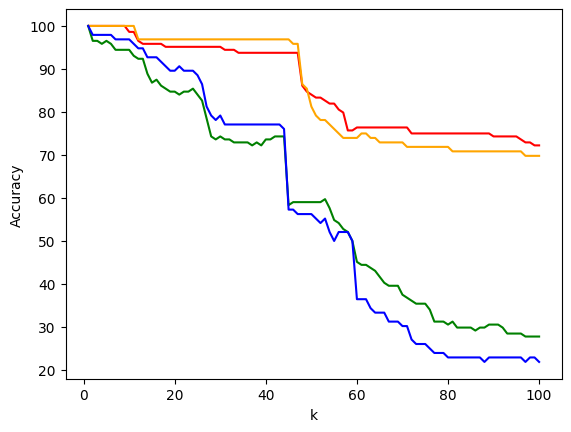

In [263]:
xs = [x for x in range(1, 101)]
ys_train, ys_test, ys_lib_train, ys_lib_test = [], [], [], []
for k in xs:
    ys_train.append(accuracy(k, X_train, y_train))
    ys_test.append(accuracy(k, X_test, y_test))
    ys_lib_train.append(lib_accuracy(k, X_train, y_train))
    ys_lib_test.append(lib_accuracy(k, X_test, y_test))
    print(k, "done")

plt.plot(xs, ys_train, color='red')
plt.plot(xs, ys_test, color='orange')
plt.plot(xs, ys_lib_train, color='green')
plt.plot(xs, ys_lib_test, color='blue')
plt.xlabel('k')
plt.ylabel('Accuracy')

# Anomaly detection

In [264]:
counter = 0
success = 0
normal, anomalies1, anomalies2 = [], [], []

for x_id in X_train.index:
    prediction = KNN.KNN(window_param=20, window_type=WindowType.VARIABLE, kernel=Kernel.TRIANGULAR,metric=Metric.MANHATTAN) \
        .fit(X_train.drop(index=x_id), y_train.drop(index=x_id), default_weights).predict(X_train.loc[[x_id]])[0]
    counter += 1
    true_class = y_train.loc[x_id]
    if true_class == prediction:
        normal.append(counter - 1)
    elif abs(true_class - prediction) == 1:
        anomalies1.append(counter - 1)
    else:
        anomalies2.append(counter - 1)

print("Accuracy", len(normal) / counter * 100)
print("Anomalies 1:", len(anomalies1))
print("Anomalies 2:", len(anomalies2))

Accuracy 95.13888888888889
Anomalies 1: 5
Anomalies 2: 2


Text(0, 0.5, 'Accuracy')

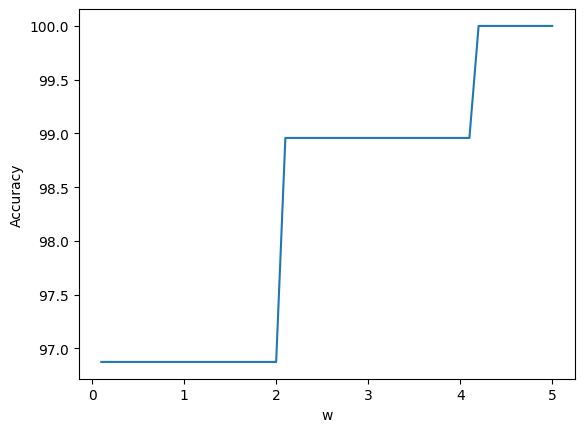

In [265]:
def get_new_weights(w):
    new_weights = []
    for i in range(len(X_train)):
        if i in anomalies1:
            new_weights.append(w)
        elif i in anomalies2:
            new_weights.append(0)
        else:
            new_weights.append(1)
    return new_weights


def get_accuracy(w, X, y):
    my_knn = KNN.KNN(
        window_param=20,
        window_type=WindowType.VARIABLE,
        kernel=Kernel.TRIANGULAR,
        metric=Metric.MANHATTAN,
    )
    predictions = my_knn.fit(X_train, y_train, get_new_weights(w)).predict(X)
    y_test_list = y.to_list()
    correct = 0
    for i in range(len(y_test_list)):
        if y_test_list[i] == predictions[i]:
            correct += 1
    accuracy = correct / len(y_test_list) * 100
    return accuracy


xs = [x / 10 for x in range(1, 51)]
ys = [get_accuracy(w, X_test, y_test) for w in xs]
plt.plot(xs, ys)
plt.xlabel('w')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

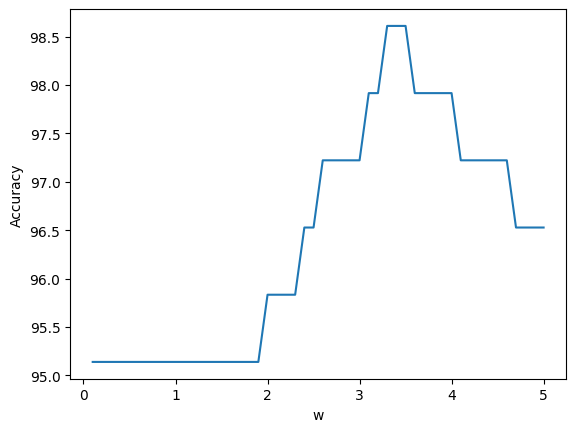

In [266]:
ys = [get_accuracy(w, X_train, y_train) for w in xs]
plt.plot(xs, ys)
plt.xlabel('w')
plt.ylabel('Accuracy')

In [267]:
def get_lib_accuracy(X, y, X_t, y_t):
    lib_knn = KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='ball_tree', p=2)
    predictions = lib_knn.fit(X, y).predict(X_t)
    y_test_list = y_t.to_list()
    correct = 0
    for i in range(len(y_test_list)):
        if y_test_list[i] == predictions[i]:
            correct += 1
    accuracy = correct / len(y_test_list) * 100
    return accuracy


X_an, y_an = X_train.iloc[anomalies1], y_train.iloc[anomalies1]
X_train_sampled, y_train_sampled = pd.concat([X_train, X_an]), pd.concat([y_train, y_an])

print("Old", get_lib_accuracy(X_train, y_train, X_test, y_test))
print("New", get_lib_accuracy(X_train_sampled, y_train_sampled, X_test, y_test))

Old 96.875
New 98.95833333333334
